In [1]:
%load_ext tensorboard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Normalization
import matplotlib.pyplot as plt
import os
from tensorboard.plugins.hparams import api as hp

# Pre-Processing Stage

#### Inputting data and getting rid of useless data points

Before this(in Excel) the data was modified to convert the date into numerical values

In [2]:
df=pd.read_csv("delhi_preprocessed.csv")

In [3]:
df.columns

Index(['date_time', 'date', 'month', 'year', 'maxtempC', 'mintempC',
       'totalSnow_cm', 'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination',
       'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph',
       'cloudcover', 'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [4]:
df

date_time  date  month  year  maxtempC  mintempC  totalSnow_cm  \
0      01-01-2009     1      1  2009        22         9             0   
1      01-01-2009     1      1  2009        22         9             0   
2      01-01-2009     1      1  2009        22         9             0   
3      01-01-2009     1      1  2009        22         9             0   
4      01-01-2009     1      1  2009        22         9             0   
...           ...   ...    ...   ...       ...       ...           ...   
96427  01-01-2020     1      1  2020        19        10             0   
96428  01-01-2020     1      1  2020        19        10             0   
96429  01-01-2020     1      1  2020        19        10             0   
96430  01-01-2020     1      1  2020        19        10             0   
96431  01-01-2020     1      1  2020        19        10             0   

       sunHour  uvIndex  uvIndex.1  ...  WindChillC  WindGustKmph  cloudcover  \
0          8.7        4          1  ...          14            19           0   
1          8.7        4          1  ...          13            21           0   
2          8.7        4          1  ...          12            22           0   
3          8.7        4          1  ...          11            23           0   
4          8.7        4          1  ...          11            21           2   
...        ...      ...        ...  ...         ...           ...         ...   
96427      8.7        5          1  ...          17            11          10   
96428      8.7        5          1  ...          16            11           9   
96429      8.7        5          1  ...          16            12           8   
96430      8.7        5          1  ...          15            11           8   
96431      8.7        5          1  ...          15            10           7   

       humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0            50       0.0      1016     10          10            331   
1            51       0.0      1016     10          10            329   
2            52       0.0      1016      9          10            327   
3            54       0.0      1016      9          10            326   
4            52       0.0      1016      9          10            318   
...         ...       ...       ...    ...         ...            ...   
96427        39       0.0      1020     17          10             96   
96428        40       0.0      1021     16          10             97   
96429        41       0.0      1021     16          10             98   
96430        42       0.0      1021     15          10             96   
96431        42       0.0      1022     15          10             94   

       windspeedKmph  
0                 12  
1                 13  
2                 13  
3                 13  
4                 13  
...              ...  
96427              9  
96428              8  
96429              8  
96430              8  
96431              8  

[96432 rows x 24 columns]

In [5]:
# df =df.drop(['time','moonrise', 'moonset','sunrise', 'sunset'], axis=1)

The next code block basically takes makes a day wise dataset by taking average over the multiple hours

In [6]:
df= df.groupby('date_time', as_index=False, sort=False)['date', 'month','year', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'uvIndex.1', 'moon_illumination', 'DewPointC',
       'FeelsLikeC', 'HeatIndexC', 'WindChillC', 'WindGustKmph', 'cloudcover',
       'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'].mean()

C:\Users\samar\AppData\Local\Temp\ipykernel_17668\17785173.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df= df.groupby('date_time', as_index=False, sort=False)['date', 'month','year', 'maxtempC', 'mintempC', 'totalSnow_cm',


In [7]:
df['date'][:]

0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
        ... 
4013    28.0
4014    29.0
4015    30.0
4016    31.0
4017     1.0
Name: date, Length: 4018, dtype: float64

This part removes any blank data points we may have

In [8]:
df2 = df.drop(['date_time'], axis=1)

In [9]:
df2=df2.dropna().reset_index(drop=True)

In [10]:
print(df2)

      date  month    year  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0      1.0    1.0  2009.0      22.0       9.0           0.0      8.7      4.0   
1      2.0    1.0  2009.0      22.0       5.0           0.0      8.7      4.0   
2      3.0    1.0  2009.0      22.0       6.0           0.0      8.7      4.0   
3      4.0    1.0  2009.0      20.0       8.0           0.0      8.7      4.0   
4      5.0    1.0  2009.0      22.0      11.0           0.0      8.7      4.0   
...    ...    ...     ...       ...       ...           ...      ...      ...   
4013  28.0   12.0  2019.0      22.0      13.0           0.0      8.7      5.0   
4014  29.0   12.0  2019.0      19.0      14.0           0.0      8.7      5.0   
4015  30.0   12.0  2019.0      20.0      14.0           0.0      7.1      5.0   
4016  31.0   12.0  2019.0      17.0      10.0           0.0      7.1      4.0   
4017   1.0    1.0  2020.0      19.0      10.0           0.0      8.7      5.0   

      uvIndex.1  moon_illum

In [11]:
df2['precipMM'] = df2['precipMM'].astype(bool)  

In [12]:
pd.set_option('display.max_columns', None)
print(df['precipMM'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4013    0.0
4014    0.0
4015    0.0
4016    0.0
4017    0.0
Name: precipMM, Length: 4018, dtype: float64


In [13]:
df2['precipMM'] = df2['precipMM'].astype(int) 
df2

date  month    year  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0      1.0    1.0  2009.0      22.0       9.0           0.0      8.7      4.0   
1      2.0    1.0  2009.0      22.0       5.0           0.0      8.7      4.0   
2      3.0    1.0  2009.0      22.0       6.0           0.0      8.7      4.0   
3      4.0    1.0  2009.0      20.0       8.0           0.0      8.7      4.0   
4      5.0    1.0  2009.0      22.0      11.0           0.0      8.7      4.0   
...    ...    ...     ...       ...       ...           ...      ...      ...   
4013  28.0   12.0  2019.0      22.0      13.0           0.0      8.7      5.0   
4014  29.0   12.0  2019.0      19.0      14.0           0.0      8.7      5.0   
4015  30.0   12.0  2019.0      20.0      14.0           0.0      7.1      5.0   
4016  31.0   12.0  2019.0      17.0      10.0           0.0      7.1      4.0   
4017   1.0    1.0  2020.0      19.0      10.0           0.0      8.7      5.0   

      uvIndex.1  moon_illumination  DewPointC  FeelsLikeC  HeatIndexC  \
0      3.041667               31.0   4.250000   14.916667   15.416667   
1      2.958333               38.0   7.750000   16.583333   16.666667   
2      3.000000               45.0   6.208333   16.125000   16.333333   
3      3.166667               52.0   4.583333   15.458333   16.041667   
4      3.083333               60.0   8.458333   16.208333   16.833333   
...         ...                ...        ...         ...         ...   
4013   3.291667                8.0   0.666667   18.583333   18.583333   
4014   3.083333               15.0  -1.791667   16.750000   17.000000   
4015   2.958333               22.0  -0.250000   16.625000   16.875000   
4016   2.666667               26.0  -3.208333   13.875000   14.416667   
4017   2.958333               37.0  -0.875000   14.333333   14.666667   

      WindChillC  WindGustKmph  cloudcover   humidity  precipMM     pressure  \
0      14.916667     16.458333    4.958333  49.875000         0  1016.208333   
1      16.583333      6.250000    2.416667  59.625000         0  1016.750000   
2      16.125000      9.500000   10.041667  54.666667         0  1016.708333   
3      15.458333     11.750000   23.083333  48.000000         0  1015.041667   
4      16.208333     11.000000   11.375000  61.375000         0  1014.666667   
...          ...           ...         ...        ...       ...          ...   
4013   18.583333      5.833333    0.000000  30.708333         0  1018.625000   
4014   16.750000      3.958333    2.583333  28.291667         0  1019.000000   
4015   16.625000      6.916667   14.041667  31.625000         0  1018.083333   
4016   13.875000      9.708333   22.916667  30.083333         0  1019.083333   
4017   14.333333      9.708333   13.500000  34.250000         0  1020.375000   

          tempC  visibility  winddirDegree  windspeedKmph  
0     12.833333        10.0     312.666667      10.500000  
1     11.875000        10.0     275.333333       3.416667  
2     12.416667        10.0     102.458333       5.125000  
3     14.458333        10.0      81.041667       6.375000  
4     14.708333        10.0     172.750000       6.250000  
...         ...         ...            ...            ...  
4013  18.583333        10.0     258.416667       4.833333  
4014  16.750000        10.0     212.916667       3.291667  
4015  16.625000        10.0      91.833333       6.166667  
4016  14.208333        10.0     120.708333       7.875000  
4017  14.500000        10.0      98.958333       7.583333  

[4018 rows x 23 columns]

In [14]:
df2.T

0            1            2            3     \
date                  1.000000     2.000000     3.000000     4.000000   
month                 1.000000     1.000000     1.000000     1.000000   
year               2009.000000  2009.000000  2009.000000  2009.000000   
maxtempC             22.000000    22.000000    22.000000    20.000000   
mintempC              9.000000     5.000000     6.000000     8.000000   
totalSnow_cm          0.000000     0.000000     0.000000     0.000000   
sunHour               8.700000     8.700000     8.700000     8.700000   
uvIndex               4.000000     4.000000     4.000000     4.000000   
uvIndex.1             3.041667     2.958333     3.000000     3.166667   
moon_illumination    31.000000    38.000000    45.000000    52.000000   
DewPointC             4.250000     7.750000     6.208333     4.583333   
FeelsLikeC           14.916667    16.583333    16.125000    15.458333   
HeatIndexC           15.416667    16.666667    16.333333    16.041667   
WindChillC           14.916667    16.583333    16.125000    15.458333   
WindGustKmph         16.458333     6.250000     9.500000    11.750000   
cloudcover            4.958333     2.416667    10.041667    23.083333   
humidity             49.875000    59.625000    54.666667    48.000000   
precipMM              0.000000     0.000000     0.000000     0.000000   
pressure           1016.208333  1016.750000  1016.708333  1015.041667   
tempC                12.833333    11.875000    12.416667    14.458333   
visibility           10.000000    10.000000    10.000000    10.000000   
winddirDegree       312.666667   275.333333   102.458333    81.041667   
windspeedKmph        10.500000     3.416667     5.125000     6.375000   

                          4            5            6            7     \
date                  5.000000     6.000000     7.000000     8.000000   
month                 1.000000     1.000000     1.000000     1.000000   
year               2009.000000  2009.000000  2009.000000  2009.000000   
maxtempC             22.000000    22.000000    21.000000    22.000000   
mintempC             11.000000     8.000000     7.000000     5.000000   
totalSnow_cm          0.000000     0.000000     0.000000     0.000000   
sunHour               8.700000     8.700000     8.700000     8.700000   
uvIndex               4.000000     4.000000     4.000000     4.000000   
uvIndex.1             3.083333     3.000000     3.000000     2.875000   
moon_illumination    60.000000    67.000000    74.000000    82.000000   
DewPointC             8.458333     9.125000     7.458333     6.958333   
FeelsLikeC           16.208333    16.208333    16.833333    16.541667   
HeatIndexC           16.833333    16.750000    17.125000    16.583333   
WindChillC           16.208333    16.208333    16.833333    16.541667   
WindGustKmph         11.000000    10.291667    13.166667     9.250000   
cloudcover           11.375000     3.416667     1.833333     0.000000   
humidity             61.375000    64.916667    55.916667    56.583333   
precipMM              0.000000     0.000000     0.000000     0.000000   
pressure           1014.666667  1015.541667  1018.291667  1021.416667   
tempC                14.708333    13.166667    13.333333    11.333333   
visibility           10.000000    10.000000    10.000000    10.000000   
winddirDegree       172.750000   159.916667   297.666667   272.458333   
windspeedKmph         6.250000     5.916667     7.750000     6.375000   

                          8            9            10           11    \
date                  9.000000    10.000000    11.000000    12.000000   
month                 1.000000     1.000000     1.000000     1.000000   
year               2009.000000  2009.000000  2009.000000  2009.000000   
maxtempC             20.000000    22.000000    21.000000    21.000000   
mintempC              3.000000    11.000000     7.000000     7.000000   
totalSnow_cm          0.000000     0.000000     0.000000     0.000000   
sunHour  

In [15]:
dftest=[]
# temp = df2.T.iloc[17,1:1+7].to_numpy()
# tempd = pd.DataFrame(temp.T,columns=['precipMM'])
# tempn = tempd.T
for i in range(1,4018-7): #3662-7
    temp = df2.T.iloc[17,i:i+7].to_numpy() #change the 7 to the 
    tempd = pd.DataFrame(temp.T,columns=['precipMM'])
    tempn = tempd.T 
    dftest.append(tempn)
    i=i+1
dfinal=pd.concat(dftest,ignore_index=True)

In [16]:
dfinal

0    1    2    3    4    5    6
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...
4005  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4006  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4007  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4008  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4009  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[4010 rows x 7 columns]

# Start Prediction Algorithem

First break the data into train, and test models .

In [17]:
df_X_train = df2.iloc[0:3660,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]] 
# df_X_train
df_X_test = df2.iloc[3660:4010,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
#df_X_test

In [18]:
df_y_train = dfinal.iloc[0:3660]
# df_y_train
df_y_test = dfinal.iloc[3660:4010]
# df_y_test

In [19]:
df_y_train

0    1    2    3    4    5    6
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...
3655  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3656  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3657  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3658  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3659  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3660 rows x 7 columns]

In [20]:
X_train = df_X_train.to_numpy()
X_test = df_X_test.to_numpy()
y_train = df_y_train.to_numpy()
y_test = df_y_test.to_numpy()

In [21]:
len(y_test)

350

In [22]:
size = X_train.shape[1]

tf.random.set_seed(1234)
model = Sequential(
    [    
        Normalization(axis=-1,), 
        tf.keras.Input(shape=(size,)),       
        Dense(22, activation = 'relu',kernel_constraint=MaxNorm(3)),
        Dropout(0.13, input_shape=(size,)),  
        Dense(10, activation = 'relu',kernel_constraint=MaxNorm(3)),
        Dropout(0.13 , input_shape=(size,)),
        # Dense(5, activation = 'relu',kernel_constraint=MaxNorm(3)),
        # Dropout(0.1 , input_shape=(size,)),
        Dense(7, activation = 'sigmoid')
    ], name = "my_model" 
)

In [23]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

In [24]:
history= model.fit(
    X_train,y_train,
    epochs=500,
    batch_size=64,
)

Epoch 1/500
58/58 [==============================] - 1s 3ms/step - loss: 52.3531
Epoch 2/500
58/58 [==============================] - 0s 4ms/step - loss: 12.6001
Epoch 3/500
58/58 [==============================] - 0s 2ms/step - loss: 3.7796
Epoch 4/500
58/58 [==============================] - 0s 2ms/step - loss: 2.3195
Epoch 5/500
58/58 [==============================] - 0s 2ms/step - loss: 1.5604
Epoch 6/500
58/58 [==============================] - 0s 2ms/step - loss: 1.3278
Epoch 7/500
58/58 [==============================] - 0s 2ms/step - loss: 1.0262
Epoch 8/500
58/58 [==============================] - 0s 2ms/step - loss: 0.9800
Epoch 9/500
58/58 [==============================] - 0s 2ms/step - loss: 0.9064
Epoch 10/500
58/58 [==============================] - 0s 2ms/step - loss: 0.8420
Epoch 11/500
58/58 [==============================] - 0s 2ms/step - loss: 0.7858
Epoch 12/500
58/58 [==============================] - 0s 2ms/step - loss: 0.7152
Epoch 13/500
58/58 [===============

In [25]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 23)               47        
 n)                                                              
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 dense (Dense)               (None, 22)                528       
                                                                 
 dropout (Dropout)           (None, 22)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                230       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                          

In [26]:
train_loss = history.history['loss']
epochs = range(1, len(train_loss) + 1)

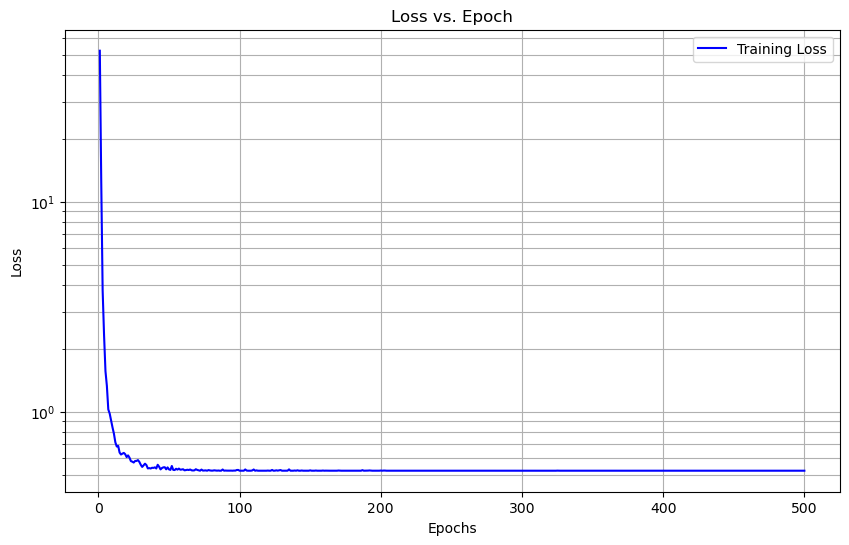

In [27]:
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epochs')
# plt.ylabel('\log_{10} Loss')
plt.ylabel('Loss')
plt.legend()
plt.yscale("log")
plt.grid(True, which='both')
plt.show()

In [28]:
count = 0
i=0
yhat=0

In [29]:
prediction1 = model.predict(X_test[255].reshape(1,size))
prediction1 [0][5]

1/1 [==============================] - 0s 94ms/step


0.21747288

In [30]:
count = 0

In [31]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
count = 0
for i in range(0,len(y_test)):
    # prediction = model.predict(X_test[i].reshape(1,size))
    prediction2 = model.predict(X_test[i].reshape(1,size))
    print(prediction2[0])
    for j in range(0,7):
        if prediction2[0][j] >= 0.5:
            yhat = 1
        else:
            yhat = 0
        # print(prediction, yhat, y_test[i],"\n")
        # print(yhat, y_test[i],"\n")
        if(yhat==y_test[i][j]):
            count = count + 1



1/1 [==============================] - 0s 27ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 23ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 23ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 24ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 23ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 23ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 23ms/step
[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
 0.21772282]
1/1 [==============================] - 0s 24ms/step
[0.21815236 0.21767436 0

In [33]:
print("The prediction is correct", (count/(7*i))*100, "% of the times!")

The prediction is correct 65.32951289398281 % of the times!


In [34]:
import random

In [35]:
count = 0
for i in range(0,300):
    # prediction = model.predict(X_test[i].reshape(1,size))
    a=random.randrange(1,4000)
    new = df2.iloc[a,].to_numpy()
    # print(new)
    prediction3 = model.predict(tf.constant(new)) #.reshape(1,size)
    check_new2 = dfinal.iloc[a,].to_numpy()
    print(prediction3)
    # print(check_new2)
    for j in range(0,7):
        if prediction3[0][j] >= 0.5:
            yhat = 1
        else:
            yhat = 0
        # print(prediction, yhat, y_test[i],"\n")
        # print(yhat, y_test[i],"\n")
        if(yhat==check_new2[j]):
            count = count + 1

1/1 [==============================] - 0s 93ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 22ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 22ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 24ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 26ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 24ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 22ms/step
[[0.21815236 0.21767436 0.21753514 0.21749038 0.21728979 0.21747288
  0.21772282]]
1/1 [==============================] - 0s 24ms/step
[[0

In [36]:
print("The prediction is correct", (count/(7*i))*100, "% of the times!")

The prediction is correct 77.20974677496416 % of the times!


In [37]:
a=random.randrange(1,4000)
new = df2.iloc[a,].to_numpy()
tf.constant((new))

<tf.Tensor: shape=(23,), dtype=float64, numpy=
array([3.00000000e+00, 2.00000000e+00, 2.01200000e+03, 2.20000000e+01,
       1.00000000e+01, 0.00000000e+00, 1.09000000e+01, 3.00000000e+00,
       3.16666667e+00, 7.60000000e+01, 7.00000000e+00, 1.53750000e+01,
       1.57500000e+01, 1.53750000e+01, 1.09166667e+01, 3.20833333e+01,
       5.84583333e+01, 0.00000000e+00, 1.01762500e+03, 1.45833333e+01,
       1.00000000e+01, 2.34041667e+02, 6.29166667e+00])>